In [1]:
import os
os.environ["CHARMM_HOME"] = "/pchem-data/meuwly/boittier/home/charmm"
os.environ["CHARMM_LIB_DIR"] = "/pchem-data/meuwly/boittier/home/charmm/build/cmake"

# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import matplotlib.pyplot as plt

In [2]:
import jax

# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

import sys
import e3x
import jax
import numpy as np
import optax
import orbax
from pathlib import Path
import pandas as pd

# Add custom path
sys.path.append("/pchem-data/meuwly/boittier/home/pycharmm_test")
import physnetjax

sys.path.append("/pchem-data/meuwly/boittier/home/dcm-lj-data")
from pycharmm_lingo_scripts import script1, script2, script3, load_dcm

from physnetjax.data.data import prepare_datasets
from physnetjax.training.loss import dipole_calc
from physnetjax.models.model import EF
from physnetjax.training.training import train_model  # from model import dipole_calc
from physnetjax.data.batches import _prepare_batches as prepare_batches #prepare_batches, prepare_datasets

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

data_key, train_key = jax.random.split(jax.random.PRNGKey(42), 2)

from pathlib import Path

from physnetjax.calc.helper_mlp import get_ase_calc

def parse_non_int(s):
    return "".join([_ for _ in s if _.isalpha()]).lower().capitalize()


NATOMS = 10

model = EF(
    # attributes
    features=128,
    max_degree=0,
    num_iterations=5,
    num_basis_functions=64,
    cutoff=10.0,
    max_atomic_number=18,
    charges=True,
    natoms=NATOMS,
    total_charge=0,
    n_res=3,
    zbl=False,
    debug=False,
)



import pycharmm

import pycharmm
import pycharmm.generate as gen
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dyn
import pycharmm.nbonds as nbonds
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.read as read
import pycharmm.write as write
import pycharmm.settings as settings
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.select as select
import pycharmm.shake as shake

from pycharmm.lib import charmm as libcharmm



import ase
from ase.io import read as read_ase
from ase import visualize
from ase.visualize import view

ev2kcalmol = 1/(ase.units.kcal / ase.units.mol)


def set_pycharmm_xyz(atom_positions):
    xyz = pd.DataFrame(atom_positions, columns=["x", "y", "z"])
    coor.set_positions(xyz)

def capture_neighbour_list():
    # Print something
    distance_command = """
    open unit 1 write form name total.dmat
    
    COOR DMAT SINGLE UNIT 1 SELE ALL END SELE ALL END
    
    close unit 1"""
    _ = pycharmm.lingo.charmm_script(distance_command)
    
    with open("total.dmat") as f:
        output_dmat = f.read()
    
    atom_number_type_dict = {}
    atom_number_resid_dict = {}
    
    pair_distance_dict = {}
    pair_resid_dict = {}
    
    for _ in output_dmat.split("\n"):
        if _.startswith("*** "):
            _, n, resid, resname, at, _ = _.split()
        
            n = int(n.split("=")[0]) - 1
            atom_number_type_dict[n] = at
            atom_number_resid_dict[n] = int(resid) - 1
            
    for _ in output_dmat.split("\n"):        
        if _.startswith("  "):
            a, b, dist = _.split()
            a = int(a) - 1
            b = int(b) - 1
            dist = float(dist)
            if (atom_number_resid_dict[a] < atom_number_resid_dict[b]):
                pair_distance_dict[(a, b)] = dist
                pair_resid_dict[(a, b)] = (atom_number_resid_dict[a], atom_number_resid_dict[b])

    return     {"atom_number_type_dict" : atom_number_type_dict,
    "atom_number_resid_dict" : atom_number_resid_dict,
    "pair_distance_dict" : pair_distance_dict,
    "pair_resid_dict" : pair_resid_dict,}

def get_forces_pycharmm():
    positions = coor.get_positions()
    force_command = """coor force sele all end"""
    _ = pycharmm.lingo.charmm_script(force_command)
    forces = coor.get_positions()
    coor.set_positions(positions)
    return forces

def view_atoms(atoms):
    return view(atoms, viewer="x3d")


from itertools import combinations

def dimer_permutations(n_mol):
    dimer_permutations = list(combinations(range(n_mol), 2))
    return dimer_permutations

def calc_pycharmm_dimers(n_mol = 20, n_atoms=5, forces=False):
    
    RANGE = len(dimer_permutations(n_mol))
    
    ele_energies = np.zeros(RANGE)
    evdw_energies = np.zeros(RANGE)
    mm_forces = np.zeros((RANGE, n_atoms*n_mol, 3))

    print(mm_forces.shape)
    print("**"*10)
    print(RANGE)
    
    for i, (a,b) in enumerate(dimer_permutations(20)):
        reset_block_no_internal()
        a += 1
        b += 1
        block = f"""BLOCK
CALL 1 SELE .NOT. (RESID {a} .OR. RESID {b}) END
CALL 2 SELE (RESID {a} .OR. RESID {b}) END
COEFF 1 1 0.0
COEFF 2 2 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0
COEFF 1 2 0.0
END
        """
        _ = pycharmm.lingo.charmm_script(block)
        # print(_)
        energy.show()
        if forces:
            f = get_forces_pycharmm().to_numpy()
            mm_forces[i] = f
        
        evdw = energy.get_vdw()
        evdw_energies[i] = evdw
        e = energy.get_elec()
        ele_energies[i] = e


    return {"ele_energies": ele_energies, "evdw_energies": evdw_energies, "mm_forces": mm_forces}

def reset_block():
        block = f"""BLOCK 
        CALL 1 SELE ALL END
          COEFF 1 1 1.0 
        END
        """
        _ = pycharmm.lingo.charmm_script(block)

def reset_block_no_internal():
        block = f"""BLOCK 
        CALL 1 SELE ALL END
          COEFF 1 1 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0 
        END
        """
        _ = pycharmm.lingo.charmm_script(block)


reset_block_no_internal()




import MDAnalysis as mda

def load_pdb_data(pdb_file):
    loaded_pdb = mda.coordinates.PDB.PDBReader(pdb_file)
    loaded_pdb = mda.topology.PDBParser.PDBParser(pdb_file)
    
    u = mda.Universe(pdb_file)
    atom_names = [s for s in list(u.atoms.names)]
    atom_positions = list(u.atoms.positions)
    atomic_numbers = np.array([ase.data.atomic_numbers[parse_non_int(s)] for s in atom_names])
    mda_resids = [s for s in list(u.atoms.resids)]
    mda_res_at_dict = {(a-1,b): i for i, (a,b) in enumerate(zip(mda_resids, atom_names))}
    charmm_res_at_dict = {(a,b): i for i, (a,b) in enumerate(zip(resids, atypes))}
    an_charmm_res_at_dict = {v: k for k,v in charmm_res_at_dict.items()}
    an_mda_res_at_dict = {v: k for k,v in mda_res_at_dict.items()}
    atom_positions = np.array(atom_positions)
    reorder = np.array([charmm_res_at_dict[an_mda_res_at_dict[i]] for i in range(len(atom_positions))])
    atom_positions = atom_positions[reorder]
    atomic_numbers = atomic_numbers[reorder]

   
    return {"atom_names" : atom_names,
    "atom_positions" : atom_positions,
    "atomic_numbers" : atomic_numbers,
    "mda_resids" : mda_resids,
    "mda_res_at_dict" : mda_res_at_dict,
    "charmm_res_at_dict" : charmm_res_at_dict,
    "an_charmm_res_at_dict" : an_charmm_res_at_dict,
    "an_mda_res_at_dict" : an_mda_res_at_dict,
    "atom_positions" : atom_positions,
    "reorder" : reorder,
    "atom_positions" : atom_positions,
    "atomic_numbers" : atomic_numbers,
    }

def get_data_mda(fn):
    pdb_file = data_path / "dcmk" / fn
    pdb_data_mda = load_pdb_data(pdb_file)
    return pdb_data_mda



######################################################################
####################### START ########################################
######################################################################

pycharmm.lingo.charmm_script(script1)
pycharmm.lingo.charmm_script(script2)


reset_block_no_internal()

pycharmm.lingo.charmm_script(load_dcm)

energy.show()
vdw = energy.get_vdw()
elec = energy.get_elec()


atypes = psf.get_atype()
atc = pycharmm.param.get_atc()
residues = psf.get_res()
psf.get_natom()

# TODO: this assumes a pure system, need to update
atoms_per_res = int(len(atypes) / len(residues))
n_res = len(residues)
resids = np.array([[i]*atoms_per_res for i in range(n_res)]).flatten()

data_path = Path("/pchem-data/meuwly/boittier/home/dcm-lj-data")
df = pd.read_csv(data_path / "formation_energies_kcal_mol.csv", sep="\t")
df["key"] = df["Cluster"].apply(lambda x: "_".join(x.split("_")[:3]).upper() )



fn = "100_lig_1_modified.pdb"
pdb_data_mda = get_data_mda(fn)
atomic_numbers, atom_positions = pdb_data_mda["atomic_numbers"], pdb_data_mda["atom_positions"]
set_pycharmm_xyz(atom_positions)

energy.show()


test_forces = get_forces_pycharmm().to_numpy()

result = calc_pycharmm_dimers(forces=True)


for k in result.keys():
    print(result[k])



summed_2body = result["mm_forces"].sum(axis=0)





[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


2025-04-01 18:03:15.573461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743523395.595710   86223 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743523395.602607   86223 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 18:03:23.223904: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.8.61. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


  
 CHARMM>     BLOCK
 WARNING from DECODI -- Zero length string being converted to 0
 Block structure initialized with   3 blocks.
 All atoms have been assigned to block 1.
 All interaction coefficients have been set to unity.
  Setting number of block exclusions nblock_excldPairs=0
  
  BLOCK>            CALL 1 SELE ALL END
 SELRPN>      0 atoms have been selected out of      0
 The selected atoms have been reassigned to block   1
  
  BLOCK>              COEFF 1 1 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0
  
  BLOCK>            END
 Matrix of Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of BOND Interaction Coefficients
 
    0.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ANGLE Interaction Coefficients
 
    0.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of DIHE Interaction Coefficients
 
    0.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of CROSS Interaction Coeff

  
 CHARMM>     
  
 CHARMM>    set base     /pchem-data/meuwly/boittier/home/dcm-lj-data
 Parameter: BASE <- "/PCHEM-DATA/MEUWLY/BOITTIER/HOME/DCM-LJ-DATA"
  
 CHARMM>    set pardir   @base
 Parameter: BASE -> "/PCHEM-DATA/MEUWLY/BOITTIER/HOME/DCM-LJ-DATA"
 Parameter: PARDIR <- "/PCHEM-DATA/MEUWLY/BOITTIER/HOME/DCM-LJ-DATA"
  
 CHARMM>    set crddir   @base
 Parameter: BASE -> "/PCHEM-DATA/MEUWLY/BOITTIER/HOME/DCM-LJ-DATA"
 Parameter: CRDDIR <- "/PCHEM-DATA/MEUWLY/BOITTIER/HOME/DCM-LJ-DATA"
  
 CHARMM>     
  
 CHARMM>    PRNLev 5
  
 CHARMM>     
  
 CHARMM>     
  
 CHARMM>    read rtf card
 MAINIO> Residue topology file being read from unit  90.
 RDTITL> * METHANOL
 RDTITL> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
  
 CHARMM>     
  
 CHARMM>    read parameter card

          PARAMETER FILE BEING READ FROM UNIT 90
 RDTITL> * METHANO

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "



 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    RDIElec  SWITch   VATOm    VSWItch 
     BYGRoup  NOEXtnd  NOEWald 
 CUTNB  =  8.000 CTEXNB =999.000 CTONNB =  6.500 CTOFNB =  7.500
 CGONNB =  0.000 CGOFNB = 10.000
 WMIN   =  1.500 WRNMXD =  0.500 E14FAC =  1.000 EPS    =  1.000
 NBXMOD =      5
 There are     1989 atom  pairs and      200 atom  exclusions.
 There are        0 group pairs and        0 group exclusions.

      ***** LEVEL  1 WARNING FROM <GTNBCT> *****
      ***** CUTNB and CTOFNB are too close for efficient heuristic update.
      ******************************************
      BOMLEV (  0) IS NOT REACHED. WRNLEV IS  5

 Generating nonbond list with Exclusion mode = 5
 == PRIMARY == SPACE FOR     4901 ATOM PAIRS AND        0 GROUP PAIRS

 General atom nonbond list generation found:
     1989 ATOM PAIRS WERE FOUND FOR ATOM LIST
      139 GROUP PAIRS REQUIRED ATOM SEARCHES

ENER ENR:  Eval#     ENERgy      Delta-E         GRMS
ENER EXTERN:        VDWaals        

In [3]:
ase_atom_full_system = ase.Atoms(atomic_numbers, atom_positions)

# ase_atoms = ase.Atoms(atomic_numbers, forces.to_numpy())

view_atoms(ase_atom_full_system)

# Can we decompose the dimer energies in CHARMM and get them in python?

In [4]:
np.mean(abs(test_forces - summed_2body))

1.351176115438335e-16

# And the CHARMM neighbour list?

In [5]:
nl_info = capture_neighbour_list()

  
 CHARMM>     
  
 CHARMM>        open unit 1 write form name total.dmat
 VOPEN> Attempting to open::total.dmat::
 OPNLGU> Unit  1 opened for WRITE access to total.dmat
  
 CHARMM>     
  
 CHARMM>        COOR DMAT SINGLE UNIT 1 SELE ALL END SELE ALL END
 DMAT: Distance matrix output to unit   1
 SELRPN>    100 atoms have been selected out of    100
 SELRPN>    100 atoms have been selected out of    100
 DMAT: Number of atoms selected for SET1 100
 DMAT: Number of atoms selected for SET2 100
  
 CHARMM>     
  
 CHARMM>        close unit 1
 VCLOSE: Closing unit    1 with status "KEEP"
  


In [6]:
nl_info.keys()

dict_keys(['atom_number_type_dict', 'atom_number_resid_dict', 'pair_distance_dict', 'pair_resid_dict'])

In [7]:
# pair_distance_dict (atom - atom pairs to distance)
# atom_number_resid_dict (atom number to res number)

In [8]:
pd_keys = list(nl_info["pair_distance_dict"].keys())
print(pd_keys[:10])
len(pd_keys)

[(0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14)]


4750

# Can we load the Physnet model and get energies for monomers and dimers?

In [9]:
from physnetjax.restart.restart import get_last, get_files, get_params_model
from physnetjax.analysis.analysis import plot_stats
# restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-af722a47-a3a3-4f31-987f-c6a9ab2fb555"
# restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d8bc5d79-f65e-451e-8169-bf6da5170b54"
restart_path = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1"

restart = get_last(restart_path)
params, dimer_model = get_params_model(restart)
dimer_model.natoms = 10
print(dimer_model)

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 64
    cutoff = 10.0
    max_atomic_number = 18
    charges = True
    natoms = 10
    total_charge = 0
    n_res = 3
    zbl = False
    debug = False
    efa = False
)


In [10]:
restart = get_last(restart_path)
params, monomer_model = get_params_model(restart)
monomer_model.natoms = 5
print(monomer_model)

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 64
    cutoff = 10.0
    max_atomic_number = 18
    charges = True
    natoms = 5
    total_charge = 0
    n_res = 3
    zbl = False
    debug = False
    efa = False
)


In [11]:
restart = get_last(restart_path)
params, cluster_model = get_params_model(restart)
cluster_model.natoms = 100
print(cluster_model)

dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 64
    cutoff = 10.0
    max_atomic_number = 18
    charges = True
    natoms = 100
    total_charge = 0
    n_res = 3
    zbl = False
    debug = False
    efa = False
)


# Creating the calculators

In [12]:
Z, R = atomic_numbers, atom_positions
Z = [_ for i, _ in enumerate(Z) if i < 5  ]
R = np.array([_ for i, _ in enumerate(R) if i < 5  ])
ase_atoms_monomer = ase.Atoms(Z, R)
# translate to center of mass
ase_atoms_monomer.set_positions(R - R.T.mean(axis=1))
view_atoms(ase_atoms_monomer)



In [13]:

# TODO: add default keys to the conversion dict
ase_calc_monomer = get_ase_calc(params, monomer_model, ase_atoms_monomer, conversion={"energy": ev2kcalmol, "dipole": 1, "forces": ev2kcalmol})
ase_atoms_monomer.calc = ase_calc_monomer
float(ase_atoms_monomer.get_potential_energy())

-385.3331604003906

In [14]:
Z, R = atomic_numbers, atom_positions
Z = [_ for i, _ in enumerate(Z) if i < 10  ]
R = np.array([_ for i, _ in enumerate(R) if i < 10  ])
ase_atoms_dimer = ase.Atoms(Z, R)
# translate to center of mass
ase_atoms_dimer.set_positions(R - R.T.mean(axis=1))
view_atoms(ase_atoms_dimer)

In [32]:
ase_atoms_dimer = ase.Atoms(Z, R)
ase_calc_dimer = get_ase_calc(params, dimer_model, ase_atoms_dimer, conversion={"energy": ev2kcalmol, "dipole": 1, "forces": ev2kcalmol})
ase_atoms_dimer.calc = ase_calc_dimer

float(ase_atoms_dimer.get_potential_energy())

-772.6849975585938

In [16]:
(ase_atoms_dimer.get_forces())

Array[10, 3] n=30 x∈[-38.140, 33.348] μ=2.543e-07 σ=16.895 gpu:0

In [17]:
R = ase_atoms_dimer.get_positions()
R

array([[ -8.02200031,  -3.03600001,   9.125     ],
       [ -6.91800022,  -4.50500011,   9.42599964],
       [ -8.21399975,  -2.00699997,  10.65200043],
       [ -9.02200031,  -3.4289999 ,   8.79800034],
       [ -7.59700012,  -2.38700008,   8.32600021],
       [-10.28499985,  -6.39300013,   6.20300007],
       [ -9.93599987,  -7.40799999,   7.68200016],
       [ -8.84700012,  -5.46099997,   5.68100023],
       [-11.18999958,  -5.76999998,   6.37599993],
       [-10.5909996 ,  -7.13100004,   5.37200022]])

In [18]:
# add some random noise and see if the energy is different
R = R + np.random.normal(0, 0.01, R.shape)
ase_atoms_dimer.set_positions(R)

In [19]:
float(ase_atoms_dimer.get_potential_energy())

-772.6851196289062

In [35]:
(ase_atoms_dimer.get_forces())

Array[10, 3] n=30 x∈[-31.282, 36.083] μ=6.358e-08 σ=15.602 gpu:0

# Mixed potential

In [113]:
def indices_of_pairs(a, b, n_atoms=5, n_mol=20):
    assert a < b, "by convention, res a must have a smaller index than res b"
    assert a >= 1, "res indices can't start from 1"
    assert b >= 1, "res indices can't start from 1"
    assert a != b, "pairs can't contain same residue"
    return np.concatenate([np.arange(0, n_atoms, 1) + (a-1)*n_atoms, np.arange(0, n_atoms, 1) + (b-1)*n_atoms])

def indices_of_monomer(a, n_atoms=5, n_mol=20):
    assert a < (n_mol+1), "monomer index outside total n molecules"
    return np.arange(0, n_atoms, 1) + (a-1)*n_atoms


def calc_physnet_via_idx_list(all_coordinates, all_idxs, calculator):
    
    RANGE = len(all_idxs)
    ml_energies = np.zeros(RANGE)
    ml_forces = np.zeros((RANGE, len(all_idxs[0]), 3))
    
    for i, idxs in enumerate(all_idxs):
        # set positions
        calculator.set_positions(all_coordinates[idxs])
        
        ml_energies[i] = calculator.get_potential_energy()
        ml_forces[i] = calculator.get_forces()


    return {"ml_energies": ml_energies, "ml_forces": ml_forces}


def get_dimer_distances(dimer_idxs, pair_distances):
    out_dists = np.zeros(len(dimer_idxs))
    for i, (a,b) in enumerate(dimer_idxs):
        a = all_monomer_idxs[a][0] # just distance to first atom in the molecule...
        b = all_monomer_idxs[b][0] # TODO: generalize...
        out_dists[i] = pair_distances[(a, b)]

    return out_dists

In [26]:
all_dimer_idxs = []
for (a,b) in dimer_permutations(20):
    all_dimer_idxs.append(indices_of_pairs(a+1, b+1))

all_monomer_idxs = []
for a in range(1, 21):
    all_monomer_idxs.append(indices_of_monomer(a))

In [111]:
all_coordinates = ase_atom_full_system.get_positions()
# all_coordinates[:10]

In [30]:
monomer_results = calc_physnet_via_idx_list(all_coordinates, all_monomer_idxs, ase_atoms_monomer)
# monomer_results

In [36]:
dimer_results = calc_physnet_via_idx_list(all_coordinates, all_dimer_idxs, ase_atoms_dimer)
# dimer_results

In [110]:
# result["mm_forces"].shape

In [109]:
summed_2body_forces = result["mm_forces"].sum(axis=0)
# summed_2body_forces.shape

In [108]:
# all_monomer_idxs
# dimer_results["ml_energies"]

In [40]:
dimer_idxs = dimer_permutations(20)
# dimer_idxs

In [107]:
summed_ml_intE = (dimer_results["ml_energies"] - monomer_results["ml_energies"][np.array(dimer_idxs)].sum(axis=1))
# summed_ml_intE

In [42]:
dimer_pair_c_c_distances = get_dimer_distances(dimer_idxs, nl_info["pair_distance_dict"])

In [43]:
# load the QM formation energy data
data_path = Path("/pchem-data/meuwly/boittier/home/dcm-lj-data")
df = pd.read_csv(data_path / "formation_energies_kcal_mol.csv", sep="\t")
df["key"] = df["Cluster"].apply(lambda x: "_".join(x.split("_")[:3]).upper() )
df

,Cluster,Cluster Energy,Monomer Sum,Formation Energy (Hartree),Formation Energy (kcal/mol),key
0,100_LIG_1,-19168.893238,-19168.826734,-0.066504,-41.731854,100_LIG_1
1,100_LIG_10,-19168.874696,-19168.806251,-0.068444,-42.949509,100_LIG_10
2,100_LIG_100,-19168.892131,-19168.828790,-0.063341,-39.747275,100_LIG_100
3,100_LIG_11,-19168.872941,-19168.815802,-0.057139,-35.855129,100_LIG_11
4,100_LIG_12,-19168.871378,-19168.821103,-0.050275,-31.547863,100_LIG_12
...,...,...,...,...,...,...
95,100_LIG_95,-19168.893409,-19168.829056,-0.064353,-40.382115,100_LIG_95
96,100_LIG_96,-19168.879736,-19168.820661,-0.059075,-37.069863,100_LIG_96
97,100_LIG_97,-19168.887691,-19168.826441,-0.061250,-38.435091,100_LIG_97
98,100_LIG_98,-19168.893152,-19168.828568,-0.064584,-40.527012,100_LIG_98


In [44]:
epsilon = 10**(-6)
from e3x.nn import smooth_switch, smooth_cutoff

def combine_with_sigmoid(r, mm_energy, ml_energy, 
                         dif = 10**(-6), 
                         MM_CUTON = 7.0, 
                         MM_CUTOFF = 14, BUFFER = 0.1,
                        debug=False):
    
    ML_CUTOFF = MM_CUTON - dif
    charmm_on_scale = smooth_switch(r, x0=ML_CUTOFF, x1=MM_CUTON)
    charmm_off_scale = smooth_cutoff(r - MM_CUTON, cutoff=MM_CUTOFF - MM_CUTON)
    # remove any sigularities
    charmm_off_scale = jax.numpy.nan_to_num(charmm_off_scale, posinf=1)
    
    ml_scale = 1 - abs(smooth_switch(r, x0=ML_CUTOFF - BUFFER, x1=ML_CUTOFF))
    ml_contrib = ml_scale * ml_energy

    mm_contrib = charmm_on_scale * mm_energy 
    mm_contrib =  mm_contrib * charmm_off_scale 

    
    return mm_contrib, ml_contrib, charmm_off_scale, charmm_on_scale, ml_scale


In [45]:
dimer_pair_c_c_distances.shape

(190,)

In [46]:
summed_ml_intE.shape

(190,)

In [47]:
summed_mm_intE = (result["ele_energies"] + result["evdw_energies"])
summed_mm_intE.shape

(190,)

In [98]:
combined_with_switches = combine_with_sigmoid(dimer_pair_c_c_distances, summed_mm_intE,  summed_ml_intE,
                                              MM_CUTON = 5.0, 
                                              MM_CUTOFF = 10.0, 
                                              BUFFER = 0.1,
                                             )
mm_contrib, ml_contrib, charmm_off_scale, charmm_on_scale, ml_scale =  combined_with_switches

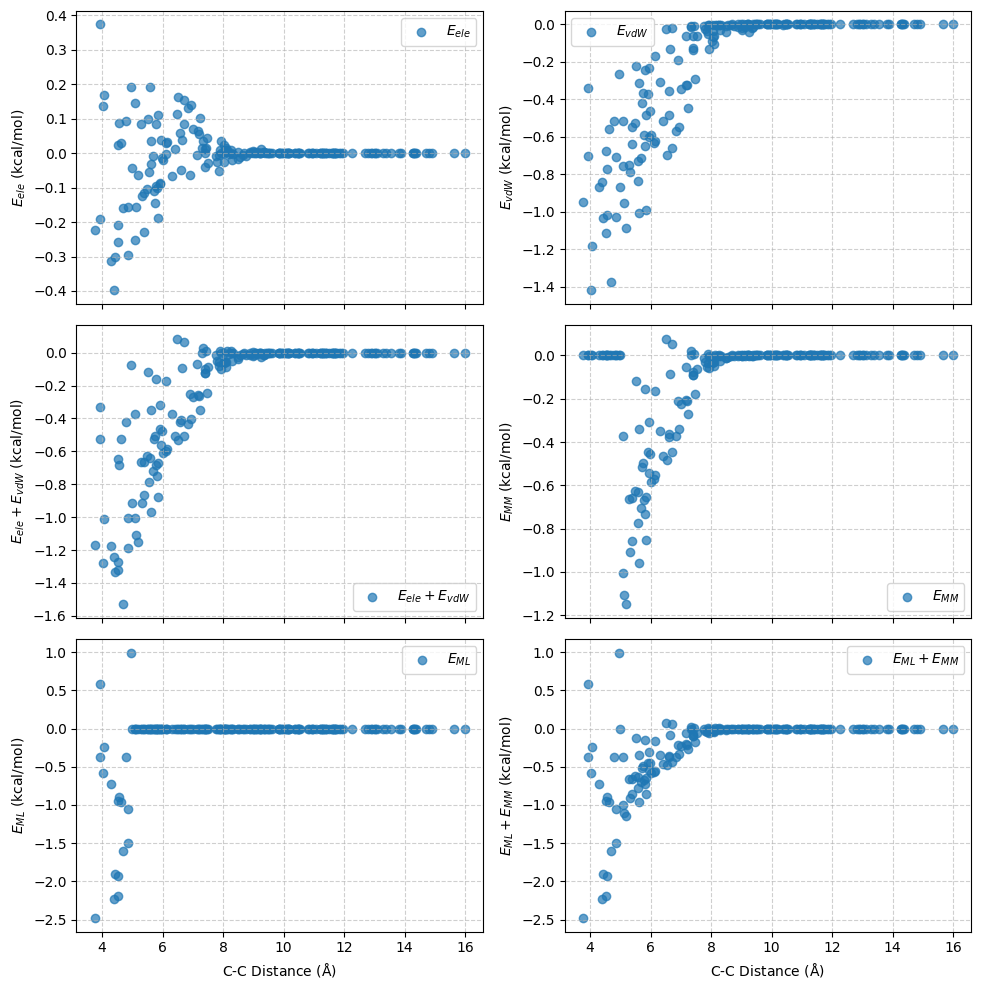

In [99]:

ele_energies = result["ele_energies"] 
evdw_energies = result["evdw_energies"]
# ional contributions
total_energy = ele_energies + evdw_energies
ml_mm_contrib = ml_contrib + mm_contrib

# Create figure and axes
fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharex=True)

# Plot each energy term
axes[0, 0].scatter(dimer_pair_c_c_distances, ele_energies, alpha=0.7, label=r"$E_{ele}$")
axes[0, 1].scatter(dimer_pair_c_c_distances, evdw_energies, alpha=0.7, label=r"$E_{vdW}$")
axes[1, 0].scatter(dimer_pair_c_c_distances, total_energy, alpha=0.7, label=r"$E_{ele} + E_{vdW}$")
axes[1, 1].scatter(dimer_pair_c_c_distances, mm_contrib, alpha=0.7, label=r"$E_{MM}$")
axes[2, 0].scatter(dimer_pair_c_c_distances, ml_contrib, alpha=0.7, label=r"$E_{ML}$")
axes[2, 1].scatter(dimer_pair_c_c_distances, ml_mm_contrib, alpha=0.7, label=r"$E_{ML} + E_{MM}$")

# Formatting
for ax, ylabel in zip(
    axes.flat,
    [
        r"$E_{ele}$ (kcal/mol)",
        r"$E_{vdW}$ (kcal/mol)",
        r"$E_{ele} + E_{vdW}$ (kcal/mol)",
        r"$E_{MM}$ (kcal/mol)",
        r"$E_{ML}$ (kcal/mol)",
        r"$E_{ML} + E_{MM}$ (kcal/mol)",
    ],
):
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_ylabel(ylabel)

# Common X-label
axes[-1, 0].set_xlabel(r"C-C Distance ($\mathrm{\AA}$)")
axes[-1, 1].set_xlabel(r"C-C Distance ($\mathrm{\AA}$)")

# Adjust layout
plt.tight_layout()
plt.show()

In [100]:
mmml_energy = float(ml_contrib.sum() + mm_contrib.sum())
mmml_energy, df.iloc[0]["Formation Energy (kcal/mol)"], abs(mmml_energy - df.iloc[0]["Formation Energy (kcal/mol)"])

(-42.24969482421875, -41.731854, 0.5178408242187515)

In [101]:
charmm = (result["ele_energies"] + result["evdw_energies"]).sum()
charmm, df.iloc[0]["Formation Energy (kcal/mol)"], abs(charmm - df.iloc[0]["Formation Energy (kcal/mol)"])

(-43.11709340946656, -41.731854, 1.385239409466564)

In [102]:
Eref = np.zeros([20], dtype=float)
Eref[1] = -0.498232909223
Eref[6] = -37.731440432799
Eref[8] = -74.878159582108
Eref[17] = -459.549260062932
full_system_Eref = Eref[ase_atoms_monomer.get_atomic_numbers()].sum() * 20

In [103]:
monomer_sum_physnet = monomer_results["ml_energies"].sum()/627.5095  + Eref[ase_atoms_monomer.get_atomic_numbers()].sum() * 20
monomer_sum_qm = df.iloc[0]["Monomer Sum"]
monomer_sum_physnet, monomer_sum_qm, abs(monomer_sum_qm - monomer_sum_physnet)*627.5095

(-19168.827889190216, -19168.826734, 0.7248928355404333)

In [104]:
# the fitting error to the monomers is ~ the fitting error for physnetnet ~0.7 kcal/mol

In [114]:
# without long range MM the interaction energies is too small, due to 2body approximation
summed_ml_intE.sum()

-33.196197509765625

In [116]:
dimers_ref_path = Path("/pchem-data/meuwly/boittier/home/dcm_dimers_MP2_20999.npz")

dimers_ref = np.load(dimers_ref_path)
dimers_ref

NpzFile '/pchem-data/meuwly/boittier/home/dcm_dimers_MP2_20999.npz' with keys: N, E, Q, D, Z...

In [117]:
dimers_ref

NpzFile '/pchem-data/meuwly/boittier/home/dcm_dimers_MP2_20999.npz' with keys: N, E, Q, D, Z...

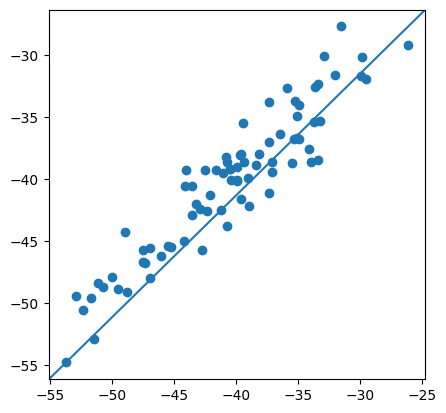

In [124]:
test = np.genfromtxt("mlmm_opt_test.dat")
plt.scatter(test[:,1], test[:,2])
ax = plt.gca()
plt.plot([0,1], [0,1], transform=ax.transAxes)
ax.set_aspect("equal")

In [ ]:
# from jax import config
# config.update('jax_enable_x64', True)
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
import e3x
import jax
import numpy as np


@jax.jit
def evaluate_energies_and_forces(atomic_numbers, positions, dst_idx, src_idx):
    return model.apply(
        params,
        atomic_numbers=atomic_numbers,
        positions=positions,
        dst_idx=dst_idx,
        src_idx=src_idx,
    )


class MessagePassingCalculator(ase_calc.Calculator):
    implemented_properties = ["energy", "forces", "dipole"]

    def calculate(
        self, atoms, properties, system_changes=ase.calculators.calculator.all_changes
    ):
        ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
        dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(atoms))
        output = evaluate_energies_and_forces(
            atomic_numbers=atoms.get_atomic_numbers(),
            positions=atoms.get_positions(),
            dst_idx=dst_idx,
            src_idx=src_idx,
        )
        if model.charges:
            self.results["dipole"] = output["dipoles"]
        self.results["energy"] = output[
            "energy"
        ].squeeze()  # * (ase.units.kcal/ase.units.mol)
        self.results["forces"] = output[
            "forces"
        ]  # * (ase.units.kcal/ase.units.mol) #/ase.units.Angstrom
